# Cat VS Dog Project

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Set Const
BATCH_SIZE: int = 20
EPOCHS: int = 100
LEARNING_RATE: float = 0.0001
DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize(150),             # Scale the image to 150x150 pixels
    transforms.RandomVerticalFlip(),    # Flip image randomly
    transforms.RandomCrop(50),          # Crop the image to 50x50 pixels randomly
    transforms.RandomResizedCrop(200),  # Crop and scale the image to 200x200 pixels randomly
    transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),   # Color enhancement
    transforms.ToTensor(),              # Turn to Tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])           # Normalize
])

In [4]:

# Read
root: str = 'imag_2000'
train_dataset = datasets.ImageFolder(root + '/train', transform=transform)
test_dataset = datasets.ImageFolder(root + '/test', transform=transform)

# Load
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
# See the shape of features and labels
for features, labels in train_loader:
    print(features.shape)
    print(labels.shape)
    break

torch.Size([20, 3, 200, 200])
torch.Size([20])


In [6]:
# Classes
train_dataset.classes

['cat', 'dog']

In [7]:
# Classes to index
train_dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [8]:
# Build model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv layers and pooling layers
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            ),
            nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            )
        ])
        # Fc layers
        self.fc_layers = nn.ModuleList([
            nn.Sequential(
                # three 2x2 pooling layers: 200 / (2 ** 3) = 25
                # 200x200 -> 25x25
                # nodes: 128x25x25
                nn.Linear(128 * 25 * 25, 512),
                nn.Dropout(0.5),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Linear(512, 256),
                nn.Dropout(0.5),
                nn.ReLU(),
            ),
            nn.Linear(256, 2),
        ])
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        x = x.view(x.size(0), -1)
        for fc_layer in self.fc_layers:
            x = fc_layer(x)
        x = self.softmax(x)
        return x

In [9]:
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training
model.train()
px, py = [], []
for epoch in range(EPOCHS):
    for features, labels in train_loader:
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        outputs: torch.Tensor = model(features)
        loss: torch.Tensor = criterion(outputs, labels).to(DEVICE)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    px.append(epoch + 1)
    py.append(loss.item())
    print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

# Save the model
torch.save(model.state_dict(), 'cat_vs_dog.pth')

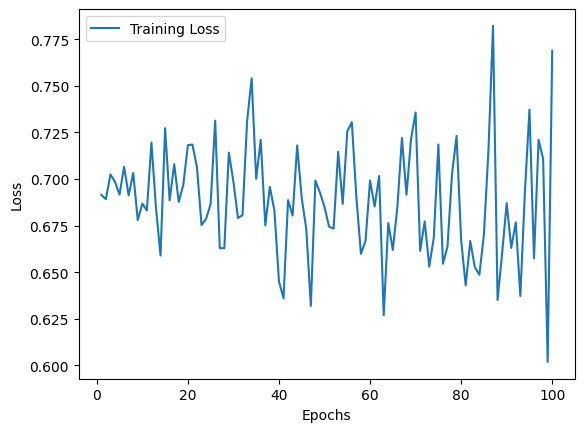

In [11]:
# Plot loss curve
plt.plot(px, py, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Test
model.eval()
with torch.no_grad():
    correct: int = 0
    total: int = 0
    for data in test_loader:
        features, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        output: torch.Tensor = model(features)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Accuracy: {accuracy}")

Accuracy: 0.552
